<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Изучение данных

Подключим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats as st

Создадим переменную state для того чтобы результаты были везде интерпретируемы

In [2]:
state = RandomState(12345)

Прочитаем все файлы

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на данные.

In [4]:
data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


Сразу можно заметить несколько вещей: 

1) Столбец id категориальный признак, его нужно каким-то образом превратить в числовой иначе наша модель не обучится

2) Признаки не масштабированны

Проверим на пропущенные значения.

In [5]:
print(data_0.isna().count())
print(data_1.isna().count())
print(data_2.isna().count())

id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64


Пропущенных значений нет. 

## Подготовка данных

Закодируем первый столбец числами

In [6]:
original_ids = data_0['id'].unique()
new_ids = {cid: uuid.uuid4().int for cid in original_ids}
data_0['id'] = data_0['id'].map(new_ids)

original_ids = data_1['id'].unique()
new_ids = {cid: uuid.uuid4().int for cid in original_ids}
data_1['id'] = data_1['id'].map(new_ids)

original_ids = data_2['id'].unique()
new_ids = {cid: uuid.uuid4().int for cid in original_ids}
data_2['id'] = data_2['id'].map(new_ids)

Проверим как это выглядит.

In [7]:
data_0

,id,f0,f1,f2,product
0,285733147758128245174639659121929154911,0.705745,-0.497823,1.221170,105.280062
1,291437057158451021262409398500965574636,1.334711,-0.340164,4.365080,73.037750
2,1996419335217927801204263377164625680,1.022732,0.151990,1.419926,85.265647
3,108808472674288430102840343973935872911,-0.032172,0.139033,2.978566,168.620776
4,226118646396275046050774616482906218062,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,124707955564475099066633969033621228892,0.971957,0.370953,6.075346,110.744026
99996,284861992397546301689285032932341404931,1.392429,-0.382606,1.273912,122.346843
99997,20547835362198663713495218422505149865,1.029585,0.018787,-1.348308,64.375443
99998,122504906687315650134843975116883399622,0.998163,-0.528582,1.583869,74.040764


Отлично, нам подходит.

(Возможно, стоило просто удалить столбец ID из данных, однако тогда мы потерям уникальный идентификатор конкретной скважины, а это может сыграть против нас)

Разделяем данные на X и Y

In [8]:
X0 = data_0.drop(['product'],axis = 1 )
X1 = data_1.drop(['product'],axis = 1 )
X2 = data_2.drop(['product'],axis = 1 )

In [9]:
y0 = data_0['product']
y1 = data_1['product']
y2 = data_2['product']

Делим на тренировочную и валидационную выборки

In [10]:
X_train0, X_valid0, y_train0, y_valid0 = train_test_split(X0,y0 , test_size=0.25, random_state=42)
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X1,y1 , test_size=0.25, random_state=42)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2,y2 , test_size=0.25, random_state=42)

In [11]:
y_train0 = y_train0.reset_index(drop=True)
y_valid0 = y_valid0.reset_index(drop=True)
y_train1 = y_train1.reset_index(drop=True)
y_valid1 = y_valid1.reset_index(drop=True)
y_train2 = y_train2.reset_index(drop=True)
y_valid2 = y_valid2.reset_index(drop=True)

Стандартизируем X

In [12]:
pd.options.mode.chained_assignment = None
scaler0 = StandardScaler()
scaler0.fit(X_train0)
scaler1 = StandardScaler()
scaler1.fit(X_train1)
scaler2 = StandardScaler()
scaler2.fit(X_train2)

StandardScaler()

In [13]:
X_train0 = scaler0.transform(X_train0)
X_valid0 = scaler0.transform(X_valid0)
X_train1 = scaler1.transform(X_train1)
X_valid1 = scaler1.transform(X_valid1)
X_train2 = scaler2.transform(X_train2)
X_valid2 = scaler2.transform(X_valid2)

## Исследование моделей

Обучаем модели на кросс валидации с подбором параметров и находим для каждой значение RMSE

In [14]:
def GridSearch (est,params,X_train,y_train):
    grid_search_cv_est = GridSearchCV(est,params,cv = 5)
    grid_search_cv_est.fit(X_train,y_train)
    best_param = grid_search_cv_est.best_params_
    best_est_est = grid_search_cv_est.best_estimator_
    return best_est_est,best_param

In [15]:
clf = LinearRegression()
params = {'fit_intercept':['False','True'],
         'normalize':['False','True'],
         'positive':['False','True']}

In [16]:
best_clf0,best_param = GridSearch(clf,params,X_train0,y_train0)
print(best_param)

{'fit_intercept': 'False', 'normalize': 'False', 'positive': 'False'}


In [17]:
prediction_values0 = best_clf0.predict(X_valid0)
#prediction_values0 = pd.Series(prediction_values0)
#prediction_values0 =prediction_values0.reset_index(drop=True)

RMSE0 = mean_squared_error(y_valid0, prediction_values0, squared=False)

In [18]:
best_clf1,best_param = GridSearch(clf,params,X_train1,y_train1)
print(best_param)

{'fit_intercept': 'False', 'normalize': 'False', 'positive': 'False'}


In [19]:
prediction_values1 = best_clf1.predict(X_valid1)
#prediction_values1= pd.Series(prediction_values1)
#prediction_values1 =prediction_values1.reset_index(drop=True)


RMSE1 = mean_squared_error(y_valid1, prediction_values1, squared=False)

In [20]:
best_clf2,best_param = GridSearch(clf,params,X_train2,y_train2)
print(best_param)

{'fit_intercept': 'False', 'normalize': 'False', 'positive': 'False'}


In [21]:
prediction_values2 = best_clf2.predict(X_valid2)
#prediction_values2 = pd.Series(prediction_values2)
#prediction_values2 =prediction_values2.reset_index(drop=True)

RMSE2 = mean_squared_error(y_valid2, prediction_values2, squared=False)

In [22]:
print(f'Средний запас предсказанного сырья для первого региона: {prediction_values0.mean()} тыс.бар, RMSE = {RMSE0}')
print(f'Средний запас предсказанного сырья для второго региона: {prediction_values1.mean()} тыс.бар, RMSE = {RMSE1}')
print(f'Средний запас предсказанного сырья для третьего региона: {prediction_values2.mean()} тыс.бар, RMSE = {RMSE2}')

Средний запас предсказанного сырья для первого региона: 92.36152527770898 тыс.бар, RMSE = 38.25440212760018
Средний запас предсказанного сырья для второго региона: 68.72121729260876 тыс.бар, RMSE = 1.5951752353767459
Средний запас предсказанного сырья для третьего региона: 94.77114786990678 тыс.бар, RMSE = 40.147122635445314


### Промежуточный вывод

Как мы видим, лучший запас предсказанного сырья в первом регионе, 92 тысячи баррелей, однако в этом же регионе достаточно большое значение RMSE. Во втором регионе 68 тысяч баррелей, но малое значение RMSЕ. Третий регион отличается средним количеством запаса нефти, но достаточно большой ошибкой.

Вывод: Первый регион хоть и с большим средним запасом нефти, но очень большой ошибкой, размер ошибки такой, что в случае разницы между предсказанным и фактическим объёмом нефти в скважине хотя бы на среднее( а вероятнее всего на большее чем среднее, так как среднее не показывает максимального значения ошибки, очевидно) объём  фактической нефти в скважине получится примерно такой же как во втором регионе, а во втором регионе ошибка крайне маленькая и соответственно он хоть и ниже, но точнее показывает результаты предсказаний. Так и зачем нам рисковать, если есть второй регион в котором мы практически точно знаем какой будет результат. Третий регион совсем не подходит так как там и небольшое значение запаса сырья, и высокая ошибка. 

Лучше всего второй регион

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [23]:
BUDGET = 10**10 
iNCOME_PER_BARREL = 450 * 10**3
N = BUDGET / iNCOME_PER_BARREL
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(N))

Точка безубыточности: 22222 тыс. баррелей


Если один баррель стоит 450 рублей, то региону необходимо добыть более 22 миллионов баррелей чтобы окупить бюджет разработки новой скважины

In [24]:
print("Средний объем нефти в скважине для безубыточного функционирования:", np.ceil(N/200))

Средний объем нефти в скважине для безубыточного функционирования: 112.0


Из этого можно сделать вывод, что запас сырья в скважинах меньше, чем точка безубыточности.

## Расчёт прибыли и рисков 

In [25]:
def profit_1(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * iNCOME_PER_BARREL
    return revenue - BUDGET

In [26]:
state = np.random.RandomState(42)

In [27]:
def func (prediction_values,target):
    prediction_values = pd.Series(prediction_values)
    revenue = []
    for _ in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = prediction_values[target_sample.index]
        revenue.append(profit_1(predictions_sample, target_sample))   # ПОДСТАВИЛ НОВУЮ ФУНКЦИЮ profit_1
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)
    revenue = pd.Series(revenue)
    print(f'Средняя прибыль: {mean_revenue}')
    print(f'Риск убытков: {risk}')
    print(f'95% доверительный интервал равен = {int(lower)} - {int(higher)}')
    plt.title('Распределение прибыли')
    plt.xlabel('Средняя прибыль')
    plt.ylabel('Частота')
    revenue.plot(kind = 'hist')

Средняя прибыль: 342770989
Риск убытков: 10.6
95% доверительный интервал равен = -216572727 - 864202897


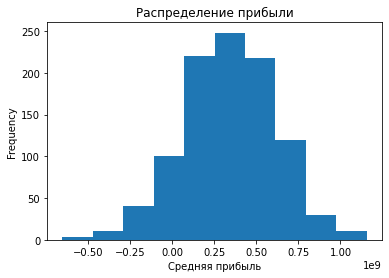

In [28]:
func(prediction_values0,y_valid0)

Средняя прибыль: 491589138
Риск убытков: 0.8
95% доверительный интервал равен = 63791499 - 914338452


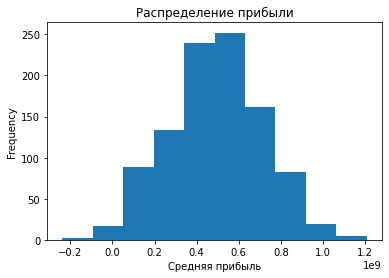

In [29]:
func(prediction_values1,y_valid1)

Средняя прибыль: 407630036
Риск убытков: 7.3
95% доверительный интервал равен = -121880326 - 961779732


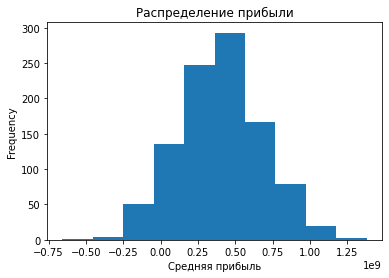

In [30]:
func(prediction_values2,y_valid2 )

## Общий вывод

Как мы видим, самый подходящий регион для разработки новой скважины эт орегион под номером 2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.